In [1]:
import numpy as np
import pandas as pd

# COCO long image des

In [15]:
total_df = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/coco_long_captions/coco_img_des_10k_bb_annot.csv")

In [16]:
total_df.head(2)

,image_id,question,answer,target_words,image_path
0,COCO_train2014_000000557315.jpg,Please describe this image in detail.,This outdoor scene captures a black bear in wh...,"[{'word': 'black', 'class': 'attribute', 'bbox...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...
1,COCO_train2014_000000106639.jpg,Please describe this image in detail.,"The image presents an inviting indoor scene, l...","[{'word': 'dining', 'class': 'attribute', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

def plot_bounding_boxes_xyxy(image_path, boxes):
    """
    Plots bounding boxes on an image using matplotlib.

    Args:
        image_path (str): Path to the image file.
        boxes (list[dict]): List of bounding boxes in dict format.
                            Each box should have keys: {'xmin', 'ymin', 'xmax', 'ymax'}
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Get a set of distinct colors
    colors = list(plt.cm.tab10.colors)
    random.shuffle(colors)

    # Draw each bounding box
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        color = colors[i % len(colors)]
        
        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=2,
                                 edgecolor=color,
                                 facecolor='none')
        ax.add_patch(rect)
        
        # Label each box
        ax.text(xmin, ymin - 5, f"Box {i+1}", color=color,
                fontsize=10, fontweight="bold", backgroundcolor='white')

    plt.axis('off')
    plt.show()

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

def _to_pil(img, image_processor=None):
    """Convert PIL / numpy / processor-normalized tensor -> PIL.Image (uint8)."""
    if isinstance(img, Image.Image):
        return img

    if isinstance(img, torch.Tensor):
        # Accept (B,3,H,W) or (3,H,W). If normalized, unnormalize via processor.
        if img.ndim == 4:
            img = img[0]
        assert img.ndim == 3 and img.shape[0] in (1,3), "Expect (C,H,W) tensor."
        x = img.clone()

        # If in [-~3, ~3] range (typical normalized), try unnormalize
        if image_processor is not None and (x.max() > 1.5 or x.min() < -0.5):
            mean = torch.tensor(
                getattr(image_processor, "image_mean", [0.5, 0.5, 0.5]),
                dtype=x.dtype, device=x.device
            )[:, None, None]
            std = torch.tensor(
                getattr(image_processor, "image_std", [0.5, 0.5, 0.5]),
                dtype=x.dtype, device=x.device
            )[:, None, None]
            x = x * std + mean

        # Move to CPU, [0,1], CHW->HWC uint8
        x = x.clamp(0,1).permute(1,2,0).detach().cpu().numpy()
        arr = (x * 255).round().astype(np.uint8)
        return Image.fromarray(arr)

    if isinstance(img, np.ndarray):
        if img.dtype != np.uint8:
            arr = np.clip(img, 0, 1)
            arr = (arr * 255).round().astype(np.uint8)
        else:
            arr = img
        if arr.ndim == 3 and arr.shape[2] == 3:
            return Image.fromarray(arr)
        raise ValueError("NumPy image must be HxWx3.")
    raise TypeError("Unsupported image type. Use PIL.Image, torch.Tensor, or np.ndarray.")

def _coerce_boxes(boxes):
    norm = []
    for b in boxes:
        if isinstance(b, dict):
            xmin, ymin, xmax, ymax = b["xmin"], b["ymin"], b["xmax"], b["ymax"]
        else:
            xmin, ymin, xmax, ymax = b  # (xmin,ymin,xmax,ymax)
        norm.append((float(xmin), float(ymin), float(xmax), float(ymax)))
    return norm

def plot_boxes_on_image(image_or_tensor, boxes, image_processor=None, labels=None,
                        linewidth=2, color="red"):
    """
    Draw bounding boxes with optional color or per-box color list.
    """
    pil = _to_pil(image_or_tensor, image_processor=image_processor)
    W, H = pil.size
    print(f"Image size: {W}x{H}")
    boxes = _coerce_boxes(boxes)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(pil)
    ax.axis("off")

    # Default color
    if color is None:
        color = "red"

    for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
        xi, yi, xa, ya = map(int, [xmin, ymin, xmax, ymax])
        left, top = min(xi, xa), min(yi, ya)
        w, h = abs(xa - xi), abs(ya - yi)

        # Allow color to be a single string or list of colors per box
        this_color = color[i] if isinstance(color, (list, tuple)) and len(color) == len(boxes) else color

        rect = Rectangle((left, top), w, h,
                         linewidth=linewidth,
                         edgecolor=this_color,
                         facecolor='none')   # <--- no fill, colored edge
        ax.add_patch(rect)

        if labels is not None:
            ax.text(left, max(10, top - 4), str(labels[i]),
                    fontsize=9,
                    color=this_color,
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1.5))

    plt.tight_layout()
    return fig, ax

In [13]:
from typing import List, Dict, Tuple, Optional
from PIL import Image
import math

def map_bboxes_to_llava336(
    image_path: str,
    boxes: List[Dict[str, int]],
    target_shortest: int = 336,
    crop_size: Tuple[int, int] = (336, 336),
    do_center_crop: bool = True,
    drop_empty: bool = True,
) -> Tuple[List[Dict[str, int]], Dict[str, int]]:
    """
    Map (xmin, ymin, xmax, ymax) boxes from original image coords to the
    LLaVA/CLIP-processed 336x336 space.
    
    Args:
        image_path: path to original image.
        boxes: list of dicts like {"xmin": int, "ymin": int, "xmax": int, "ymax": int}
        target_shortest: shortest edge after resize (typically 336 for LLaVA-1.5 @336).
        crop_size: final crop size (h, w). Typically (336, 336).
        do_center_crop: True to mirror CLIP’s center crop; False if your pipeline skipped crop.
        drop_empty: if True, discard boxes that have no overlap after crop. If False, returns
                    clipped zero/negative-area boxes (still clipped to [0, crop_dim]).
    
    Returns:
        (new_boxes, params)
        new_boxes: list of dicts in same structure with integer coords within [0, crop_dim].
        params: dict with scale and offsets used: 
                {"scale": s, "resized_h": Hs, "resized_w": Ws, "offset_x": ox, "offset_y": oy,
                 "out_h": out_h, "out_w": out_w}
    """
    # 1) Read dims
    with Image.open(image_path) as im:
        W, H = im.size  # PIL: (width, height)
    
    # 2) Resize to set shortest edge = target_shortest
    shortest = min(H, W)
    s = target_shortest / float(shortest)
    Hs = int(round(H * s))
    Ws = int(round(W * s))
    
    # 3) Center crop params (if enabled)
    out_h, out_w = crop_size
    if do_center_crop:
        ox = max(0, (Ws - out_w) // 2)  # crop left in resized space
        oy = max(0, (Hs - out_h) // 2)  # crop top  in resized space
    else:
        # No crop → output is just the resized image
        ox = 0
        oy = 0
        out_h, out_w = Hs, Ws
    
    def _transform_one(b):
        # scale with safe rounding (expand slightly after scale)
        xmin_s = math.floor(b["xmin"] * s)
        ymin_s = math.floor(b["ymin"] * s)
        xmax_s = math.ceil(b["xmax"] * s)
        ymax_s = math.ceil(b["ymax"] * s)
        
        # shift by crop offsets
        xmin_c = xmin_s - ox
        ymin_c = ymin_s - oy
        xmax_c = xmax_s - ox
        ymax_c = ymax_s - oy
        
        # clip to output frame
        xmin_c = max(0, min(out_w, xmin_c))
        ymin_c = max(0, min(out_h, ymin_c))
        xmax_c = max(0, min(out_w, xmax_c))
        ymax_c = max(0, min(out_h, ymax_c))
        
        return {"xmin": int(xmin_c), "ymin": int(ymin_c), "xmax": int(xmax_c), "ymax": int(ymax_c)}
    
    mapped = []
    for b in boxes:
        nb = _transform_one(b)
        if drop_empty:
            if nb["xmax"] > nb["xmin"] and nb["ymax"] > nb["ymin"]:
                mapped.append(nb)
        else:
            mapped.append(nb)
    
    params = {
        "scale": s,
        "resized_h": Hs,
        "resized_w": Ws,
        "offset_x": ox,
        "offset_y": oy,
        "out_h": out_h,
        "out_w": out_w,
    }
    return mapped, params

In [14]:
def apply_downscale_bb(image_path, bb_info):
    bb_info = eval(bb_info)
    ds_bb_info = []
    for i in bb_info:
        new_boxes, _ = map_bboxes_to_llava336(
            image_path=image_path,
            boxes = i["bbox"],
            target_shortest=336,
            crop_size=(336, 336),
            do_center_crop=True,
            drop_empty=False
        )
        i["bbox"] = new_boxes
        ds_bb_info.append(i)
    return ds_bb_info

In [17]:
total_df.head(2)

,image_id,question,answer,target_words,image_path
0,COCO_train2014_000000557315.jpg,Please describe this image in detail.,This outdoor scene captures a black bear in wh...,"[{'word': 'black', 'class': 'attribute', 'bbox...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...
1,COCO_train2014_000000106639.jpg,Please describe this image in detail.,"The image presents an inviting indoor scene, l...","[{'word': 'dining', 'class': 'attribute', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...


In [31]:
total_df.index

RangeIndex(start=0, stop=13943, step=1)

In [32]:
from tqdm import tqdm
all_ds_bb_info = []
faild = []
for inx, row in tqdm(total_df.iterrows(), total=total_df.shape[0]):
    try:
        image_path = "/Data2/Arun-UAV/NLP/vision_halu/train_datasets/poc_5000_coco_images/" + row["image_id"]
        ds_bb_info = apply_downscale_bb(image_path, row["target_words"])
        all_ds_bb_info.append(ds_bb_info)
    except Exception as e:
        faild.append(inx)
    

100%|██████████| 13943/13943 [01:02<00:00, 222.02it/s]


In [34]:
total_df = total_df.drop(index=faild)

In [35]:
total_df.shape

(13942, 5)

In [36]:
total_df["downscale_target_words_bb_info"] = all_ds_bb_info

In [37]:
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
image_processor = CLIPImageProcessor.from_pretrained('openai/clip-vit-large-patch14-336')

/home/user/.conda/envs/shdm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/user/.conda/envs/shdm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [73]:
i = 1318
image_path = total_df["image_path"].iloc[i]
print(len(eval(total_df["target_words"].iloc[i])))
print(len(total_df["downscale_target_words_bb_info"].iloc[i]))
print(total_df["question"].iloc[i])
print(total_df["answer"].iloc[i])

25
25
Please describe this image in detail.
This outdoor scene, bathed in the soft, diffused light of what appears to be late morning or early afternoon, captures an intimate moment between humans and a majestic elephant within a rustic, open-air structure. The central focus is a large, grey-skinned elephant, its head and trunk prominent in the foreground, stepping onto a slatted wooden platform. Its large, leathery ears are visible, and its trunk is gracefully curled, suggesting a gentle demeanor. Tufts of hay or dried grass are visible on the top of its head, hinting at its recent activities or diet. The elephant's front right foot is firmly placed on the wooden planks, indicating it is either approaching or preparing to interact with the people inside the structure. 

To the left, a human hand, possibly belonging to a caretaker or visitor, extends towards a clear plastic water bottle resting on a wooden post, suggesting an offering or preparation for the elephant. The structure itse

In [74]:
j = 15
eval(total_df["target_words"].iloc[i])[j]

{'word': 'foot',
 'class': 'object',
 'bbox': [{'xmin': 97, 'ymin': 113, 'xmax': 300, 'ymax': 403}]}

In [75]:
total_df["downscale_target_words_bb_info"].iloc[i][j]

{'word': 'foot',
 'class': 'object',
 'bbox': [{'xmin': 86, 'ymin': 45, 'xmax': 269, 'ymax': 306}]}

In [76]:
from PIL import Image

image = Image.open(image_path).convert("RGB")
image_tensor = image_processor([image], return_tensors="pt")["pixel_values"]

Image size: 336x336


(<Figure size 600x600 with 1 Axes>, <Axes: >)

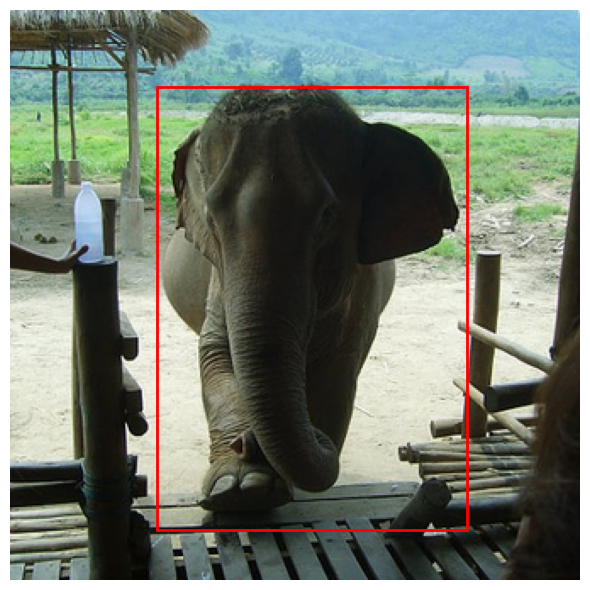

In [77]:
plot_boxes_on_image(image_tensor, total_df["downscale_target_words_bb_info"].iloc[i][j]["bbox"], image_processor=image_processor, labels=None,
                        linewidth=2, color="red")

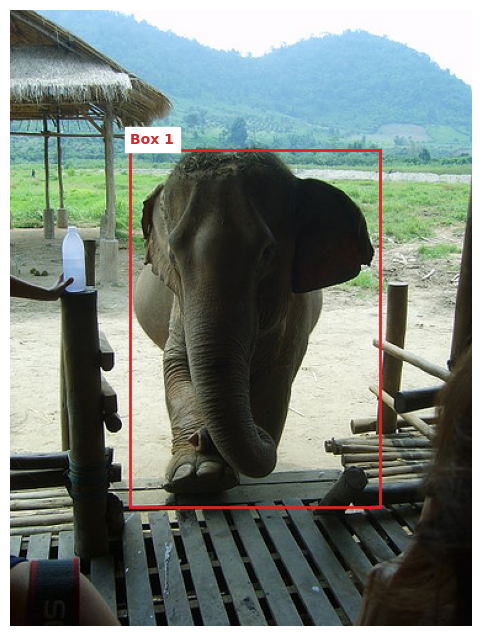

In [78]:
plot_bounding_boxes_xyxy(image_path, eval(total_df["target_words"].iloc[i])[j]["bbox"])

In [82]:
pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/coco_long_captions/downscaled_total_coco_evidence_head_train_data_15k.csv")

,image_id,question,answer,target_words,image_path,downscale_target_words_bb_info
0,COCO_train2014_000000557315.jpg,Please describe this image in detail.,This outdoor scene captures a black bear in wh...,"[{'word': 'black', 'class': 'attribute', 'bbox...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'black', 'class': 'attribute', 'bbox..."
1,COCO_train2014_000000106639.jpg,Please describe this image in detail.,"The image presents an inviting indoor scene, l...","[{'word': 'dining', 'class': 'attribute', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'dining', 'class': 'attribute', 'bbo..."
2,COCO_train2014_000000108314.jpg,Please describe this image in detail.,"This indoor, close-up shot captures a delectab...","[{'word': 'round', 'class': 'attribute', 'bbox...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'round', 'class': 'attribute', 'bbox..."
3,COCO_train2014_000000093657.jpg,Please describe this image in detail.,"This outdoor, monochromatic photograph capture...","[{'word': 'air', 'class': 'attribute', 'bbox':...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'air', 'class': 'attribute', 'bbox':..."
4,COCO_train2014_000000519181.jpg,Please describe this image in detail.,"This outdoor scene, bathed in soft, natural da...","[{'word': 'rugged', 'class': 'attribute', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'rugged', 'class': 'attribute', 'bbo..."
...,...,...,...,...,...,...
13937,COCO_train2014_000000399650.jpg,Please describe this image in detail.,"The image captures an indoor scene, likely a k...","[{'word': 'wood', 'class': 'attribute', 'bbox'...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'wood', 'class': 'attribute', 'bbox'..."
13938,COCO_train2014_000000291770.jpg,Please describe this image in detail.,"The image captures an outdoor scene, likely a ...","[{'word': 'inside', 'class': 'relation', 'bbox...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'inside', 'class': 'relation', 'bbox..."
13939,COCO_train2014_000000289312.jpg,Please describe this image in detail.,The image captures an outdoor scene at an airp...,"[{'word': 'white', 'class': 'attribute', 'bbox...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'white', 'class': 'attribute', 'bbox..."
13940,COCO_train2014_000000085404.jpg,Please describe this image in detail.,This indoor scene captures a cluttered kitchen...,"[{'word': 'silver', 'class': 'attribute', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'silver', 'class': 'attribute', 'bbo..."
